In [71]:
import pandas as pd
import numpy as np
import warnings

# Suppress all runtime warnings (e.g., divide by zero, overflow)
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(all='ignore')

cars_LinearRegression = pd.read_parquet("cars_ready_LinearRegression_small.parquet")
print("Price" in cars_LinearRegression.columns)
print(cars_LinearRegression.columns.tolist())


cars_DecisionTree = pd.read_parquet("cars_ready_DecisionTree_small.parquet")
print("Price" in cars_DecisionTree.columns)
print(cars_DecisionTree.columns.tolist())


cars_BART = pd.read_parquet("cars_ready_BART.parquet")
print("Price" in cars_BART.columns)
print(cars_BART.columns.tolist())

False
['Mileage', 'Log_Mileage', 'Age', 'Log_Age', 'Mileage_per_Year', 'Engine_Power', 'Engine_Capacity', 'Power_per_Liter', 'No_Accidents', 'Service_Record', 'Is_Imported', 'First_Owner', 'Professional_Seller', 'Make_Aixam', 'Make_Alfa Romeo', 'Make_Audi', 'Make_Baic', 'Make_Bentley', 'Make_Bmw', 'Make_Cadillac', 'Make_Chevrolet', 'Make_Chrysler', 'Make_Citroën', 'Make_Cupra', 'Make_Dacia', 'Make_Daihatsu', 'Make_Dodge', 'Make_Ds Automobiles', 'Make_Fiat', 'Make_Ford', 'Make_Honda', 'Make_Hyundai', 'Make_Infiniti', 'Make_Isuzu', 'Make_Iveco', 'Make_Jaecoo', 'Make_Jaguar', 'Make_Jeep', 'Make_Kia', 'Make_Lamborghini', 'Make_Lancia', 'Make_Land Rover', 'Make_Lexus', 'Make_Maserati', 'Make_Mazda', 'Make_Mercedes-Benz', 'Make_Mg', 'Make_Mini', 'Make_Mitsubishi', 'Make_Nissan', 'Make_Opel', 'Make_Peugeot', 'Make_Porsche', 'Make_Ram', 'Make_Renault', 'Make_Saab', 'Make_Seat', 'Make_Skoda', 'Make_Smart', 'Make_Ssangyong/Kgm', 'Make_Subaru', 'Make_Suzuki', 'Make_Tesla', 'Make_Toyota', 'Make_Vo

In [72]:
pd.set_option('display.max_columns', None)
cars_LinearRegression.head()

,Mileage,Log_Mileage,Age,Log_Age,Mileage_per_Year,Engine_Power,Engine_Capacity,Power_per_Liter,No_Accidents,Service_Record,Is_Imported,First_Owner,Professional_Seller,Make_Aixam,Make_Alfa Romeo,Make_Audi,Make_Baic,Make_Bentley,Make_Bmw,Make_Cadillac,Make_Chevrolet,Make_Chrysler,Make_Citroën,Make_Cupra,Make_Dacia,Make_Daihatsu,Make_Dodge,Make_Ds Automobiles,Make_Fiat,Make_Ford,Make_Honda,Make_Hyundai,Make_Infiniti,Make_Isuzu,Make_Iveco,Make_Jaecoo,Make_Jaguar,Make_Jeep,Make_Kia,Make_Lamborghini,Make_Lancia,Make_Land Rover,Make_Lexus,Make_Maserati,Make_Mazda,Make_Mercedes-Benz,Make_Mg,Make_Mini,Make_Mitsubishi,Make_Nissan,Make_Opel,Make_Peugeot,Make_Porsche,Make_Ram,Make_Renault,Make_Saab,Make_Seat,Make_Skoda,Make_Smart,Make_Ssangyong/Kgm,Make_Subaru,Make_Suzuki,Make_Tesla,Make_Toyota,Make_Volkswagen,Make_Volvo,Make_Model_Aixam City,Make_Model_Alfa Romeo 147,Make_Model_Alfa Romeo 159,Make_Model_Alfa Romeo Giulia,Make_Model_Alfa Romeo Giulietta,Make_Model_Alfa Romeo Gt,Make_Model_Alfa Romeo Mito,Make_Model_Alfa Romeo Stelvio,Make_Model_Alfa Romeo Tonale,Make_Model_Audi 80,Make_Model_Audi A1,Make_Model_Audi A2,Make_Model_Audi A3,Make_Model_Audi A4,Make_Model_Audi A4 Allroad,Make_Model_Audi A5,Make_Model_Audi A6,Make_Model_Audi A6 Allroad,Make_Model_Audi A7 Sportback,Make_Model_Audi A8,Make_Model_Audi E-Tron,Make_Model_Audi E-Tron Gt,Make_Model_Audi Q2,Make_Model_Audi Q3,Make_Model_Audi Q3 Sportback,Make_Model_Audi Q4 E-Tron,Make_Model_Audi Q5,Make_Model_Audi Q5 Sportback,Make_Model_Audi Q7,Make_Model_Audi Q8,Make_Model_Audi R8 Coupé,Make_Model_Audi Rs Q8,Make_Model_Audi Rs3 Sportback,Make_Model_Audi Rs4,Make_Model_Audi Rs5,Make_Model_Audi Rs6,Make_Model_Audi Rs7 Sportback,Make_Model_Audi S3,Make_Model_Audi S4,Make_Model_Audi S5,Make_Model_Audi S6,Make_Model_Audi S7 Sportback,Make_Model_Audi S8,Make_Model_Audi Sq5,Make_Model_Audi Sq7,Make_Model_Audi Sq8,Make_Model_Audi Tt Coupé,Make_Model_Audi Tt S Coupé,Make_Model_Baic Beijing 5,Make_Model_Bentley Continental Gt,Make_Model_Bentley Flying Spur,Make_Model_Bmw 3Gt,Make_Model_Bmw 5Gt,Make_Model_Bmw 6Gt,Make_Model_Bmw I3,Make_Model_Bmw I4,Make_Model_Bmw Ix,Make_Model_Bmw Ix1,Make_Model_Bmw M2,Make_Model_Bmw M3,Make_Model_Bmw M4,Make_Model_Bmw M5,Make_Model_Bmw M6,Make_Model_Bmw M8,Make_Model_Bmw Seria 1,Make_Model_Bmw Seria 2,Make_Model_Bmw Seria 3,Make_Model_Bmw Seria 4,Make_Model_Bmw Seria 5,Make_Model_Bmw Seria 6,Make_Model_Bmw Seria 7,Make_Model_Bmw Seria 8,Make_Model_Bmw X1,Make_Model_Bmw X2,Make_Model_Bmw X3,Make_Model_Bmw X3 M,Make_Model_Bmw X4,Make_Model_Bmw X4 M,Make_Model_Bmw X5,Make_Model_Bmw X5 M,Make_Model_Bmw X6,Make_Model_Bmw X6M,Make_Model_Bmw X7,Make_Model_Bmw Z3,Make_Model_Bmw Z4,Make_Model_Cadillac Escalade,Make_Model_Chevrolet Aveo,Make_Model_Chevrolet Camaro,Make_Model_Chevrolet Captiva,Make_Model_Chevrolet Corvette,Make_Model_Chevrolet Cruze,Make_Model_Chevrolet Orlando,Make_Model_Chevrolet Spark,Make_Model_Chevrolet Trax,Make_Model_Chrysler 300C,Make_Model_Chrysler Grand Voyager,Make_Model_Chrysler Pacifica,Make_Model_Chrysler Town & Country,Make_Model_Citroën Berlingo,Make_Model_Citroën C-Crosser,Make_Model_Citroën C-Elysée,Make_Model_Citroën C1,Make_Model_Citroën C2,Make_Model_Citroën C3,Make_Model_Citroën C3 Aircross,Make_Model_Citroën C3 Picasso,Make_Model_Citroën C4,Make_Model_Citroën C4 Aircross,Make_Model_Citroën C4 Cactus,Make_Model_Citroën C4 Grand Picasso,Make_Model_Citroën C4 Picasso,Make_Model_Citroën C4 Spacetourer,Make_Model_Citroën C4X,Make_Model_Citroën C5,Make_Model_Citroën C5 Aircross,Make_Model_Citroën C5X,Make_Model_Citroën C8,Make_Model_Citroën Ds3,Make_Model_Citroën Ds4,Make_Model_Citroën Ds5,Make_Model_Citroën Jumper,Make_Model_Citroën Jumpy Combi,Make_Model_Citroën Spacetourer,Make_Model_Citroën Xsara Picasso,Make_Model_Cupra Ateca,Make_Model_Cupra Formentor,Make_Model_Cupra Leon,Make_Model_Cupra Leon Sportstourer,Make_Model_Cupra Terramar,Make_Model_Dacia Dokker,Make_Model_Dacia Duster,Make_Model_Dacia Jogger,Make_Model_Dacia Lodgy,Make_M

In [73]:
# --- Przygotowanie danych do modeli neuronowych ---

# Pracujemy na danych z 'cars_ready_LinearRegression_small.parquet'
df = cars_LinearRegression.copy()

# Podział na zbiór treningowy i testowy
train_df = df[df["cv_fold"] != -1].copy()
test_df = df[df["cv_fold"] == -1].copy()

# Separacja cech i celu
X_train = train_df.drop(columns=["Log_Price", "cv_fold", "split"])
y_train = train_df["Log_Price"]

X_test = test_df.drop(columns=["Log_Price", "cv_fold", "split"])
y_test = test_df["Log_Price"]

# Sprawdzenie braków i usunięcie wierszy z brakami
mask_valid = X_train.notna().all(axis=1)
X_train = X_train[mask_valid]
y_train = y_train[mask_valid]

# Zestawienie informacji o zbiorach
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Wypisanie typów danych (np. potrzebne do późniejszego rozdzielenia na ciągłe i kategoryczne)
print("\nDtypes:")
print(X_train.dtypes.value_counts())
# --- Rozdzielenie cech na ciągłe i kategoryczne ---

# Założenie: cechy typu 'float' to cechy ciągłe (np. standaryzowane), reszta to kategorie binarne lub zakodowane
numerical_cols = X_train.select_dtypes(include=["float32", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["int64", "int32", "bool"]).columns.tolist()

print(f"🧮 Continuous features ({len(numerical_cols)}):")
print(numerical_cols[:10], "...")

print(f"\n🔢 Categorical/Binary features ({len(categorical_cols)}):")
print(categorical_cols[:10], "...")


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler




# --- Ustawienia losowości ---
RANDOM_STATE = 42

# --- Dane do sieci neuronowych i TabNet ---
df = cars_DecisionTree.copy()

# --- Podział: train/test na podstawie kolumny cv_fold ---
train_df = df[df["cv_fold"] != -1].copy()
test_df = df[df["cv_fold"] == -1].copy()

# --- Cechy ciągłe i kategoryczne (lista z poprzedniego kroku) ---
continuous_features = [
    col for col in df.columns
    if col.startswith("desc_pca_") or col in [
        'Mileage', 'Log_Mileage', 'Age', 'Log_Age',
        'Mileage_per_Year', 'Engine_Power',
        'Engine_Capacity', 'Power_per_Liter'
    ]
]

categorical_features = [
    col for col in df.columns
    if col not in continuous_features + ['Log_Price', 'Price', 'cv_fold', 'split']
]

# --- Usunięcie braków w cechach ciągłych ---
train_df = train_df.dropna(subset=continuous_features)
test_df = test_df.dropna(subset=continuous_features)

# --- Dane wejściowe ---
X_train_cont = train_df[continuous_features].astype(np.float32).copy()
X_test_cont = test_df[continuous_features].astype(np.float32).copy()

X_train_cat = train_df[categorical_features].astype(np.float32).copy()
X_test_cat = test_df[categorical_features].astype(np.float32).copy()

# --- Skalowanie cech ciągłych ---
scaler = StandardScaler()
X_train_cont_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_cont),
    columns=X_train_cont.columns,
    index=X_train_cont.index
)
X_test_cont_scaled = pd.DataFrame(
    scaler.transform(X_test_cont),
    columns=X_test_cont.columns,
    index=X_test_cont.index
)

# --- Połączenie danych do modelu MLP ---
X_train_mlp = pd.concat([X_train_cont_scaled, X_train_cat], axis=1)
X_test_mlp = pd.concat([X_test_cont_scaled, X_test_cat], axis=1)

y_train = train_df["Log_Price"]
y_test = test_df["Log_Price"]

print(f"✅ Final MLP input shape: {X_train_mlp.shape}")
# Konwersja do NumPy (dla KFold i Pytorch)
X_train_cv = X_train.values.astype(np.float32)
y_train_cv = y_train.values.astype(np.float32).reshape(-1, 1)

X_train shape: (165236, 789)
X_test shape: (41309, 789)
y_train shape: (165236,)
y_test shape: (41309,)

Dtypes:
int64      731
float32     50
float64      8
Name: count, dtype: int64
🧮 Continuous features (58):
['Mileage', 'Log_Mileage', 'Age', 'Log_Age', 'Mileage_per_Year', 'Engine_Power', 'Engine_Capacity', 'Power_per_Liter', 'desc_pca_0', 'desc_pca_1'] ...

🔢 Categorical/Binary features (731):
['No_Accidents', 'Service_Record', 'Is_Imported', 'First_Owner', 'Professional_Seller', 'Make_Aixam', 'Make_Alfa Romeo', 'Make_Audi', 'Make_Baic', 'Make_Bentley'] ...
✅ Final MLP input shape: (165236, 119)


In [ ]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold  

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout=[0.2, 0.1]):  
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        # Ensure dropout is a list with same length as hidden_dims
        if isinstance(dropout, (int, float)):
            dropout = [dropout] * len(hidden_dims)
        
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.LayerNorm(dims[i + 1]))  # LayerNorm better for tabular data
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout[i]))  # Progressive dropout
        
        layers.append(nn.Linear(dims[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [75]:


DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# --- Cross-validation ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []         # RMSE
cv_maes = []           # MAE
cv_r2 = []             # R2
all_mae_curves = []    # MAE per epoch per fold (for average learning curve)
mae_fold1 = []         # MAE per epoch for Fold 1 (for individual learning curve)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_cv)):
    print(f"\n🔁 Fold {fold+1}/5")

    X_fold_train = torch.tensor(X_train_cv[train_idx])
    y_fold_train = torch.tensor(y_train_cv[train_idx])
    X_fold_val = torch.tensor(X_train_cv[val_idx])
    y_fold_val = torch.tensor(y_train_cv[val_idx])

    train_loader = DataLoader(TensorDataset(X_fold_train, y_fold_train), batch_size=1024, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_fold_val, y_fold_val), batch_size=1024)

    model = MLP(input_dim=X_train_cv.shape[1]).to(DEVICE)
    # Added weight decay and learning rate scheduler for better training
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    criterion = nn.MSELoss()

    best_loss = np.inf
    patience = 7  # Increased for larger model
    wait = 0
    val_mae_per_epoch = []

    for epoch in range(50):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                val_preds.append(model(xb).cpu())
                val_targets.append(yb)

        val_preds = torch.cat(val_preds).numpy()
        val_targets = torch.cat(val_targets).numpy()
        val_rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
        val_mae = mean_absolute_error(val_targets, val_preds)
        val_r2 = r2_score(val_targets, val_preds)

        val_mae_per_epoch.append(val_mae)

        print(f"Epoch {epoch+1}: MAE = {val_mae:.4f}")
        
        # Update learning rate based on validation loss
        scheduler.step(val_rmse)

        if val_rmse < best_loss:
            best_loss = val_rmse
            best_mae = val_mae
            best_r2 = val_r2
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("⏹️ Early stopping")
                break

    cv_scores.append(best_loss)
    cv_maes.append(best_mae)
    cv_r2.append(best_r2)
    all_mae_curves.append(val_mae_per_epoch)
    if fold == 0:
        mae_fold1 = val_mae_per_epoch
    



Using device: mps

🔁 Fold 1/5
Epoch 1: MAE = 0.7363
Epoch 2: MAE = 0.3372
Epoch 3: MAE = 0.2548
Epoch 4: MAE = 0.2278
Epoch 5: MAE = 0.2136
Epoch 6: MAE = 0.2024
Epoch 7: MAE = 0.1961
Epoch 8: MAE = 0.1853
Epoch 9: MAE = 0.1807
Epoch 10: MAE = 0.1730
Epoch 11: MAE = 0.1667
Epoch 12: MAE = 0.1650
Epoch 13: MAE = 0.1692
Epoch 14: MAE = 0.1622
Epoch 15: MAE = 0.1581
Epoch 16: MAE = 0.1581
Epoch 17: MAE = 0.1551
Epoch 18: MAE = 0.1573
Epoch 19: MAE = 0.1578
Epoch 20: MAE = 0.1558
Epoch 21: MAE = 0.1536
Epoch 22: MAE = 0.1514
Epoch 23: MAE = 0.1525
Epoch 24: MAE = 0.1587
Epoch 25: MAE = 0.1538
Epoch 26: MAE = 0.1504
Epoch 27: MAE = 0.1527
Epoch 28: MAE = 0.1507
Epoch 29: MAE = 0.1686
Epoch 30: MAE = 0.1515
Epoch 31: MAE = 0.1452
Epoch 32: MAE = 0.1454
Epoch 33: MAE = 0.1452
Epoch 34: MAE = 0.1452
Epoch 35: MAE = 0.1452
Epoch 36: MAE = 0.1488
Epoch 37: MAE = 0.1468
Epoch 38: MAE = 0.1444
Epoch 39: MAE = 0.1508
Epoch 40: MAE = 0.1675
Epoch 41: MAE = 0.1450
Epoch 42: MAE = 0.1464
Epoch 43: MAE

In [76]:
# --- Final Training with Early Stopping ---
from torch.utils.data import DataLoader, TensorDataset, random_split

# Przygotowanie danych
X_all = torch.tensor(X_train_cv, dtype=torch.float32)
y_all = torch.tensor(y_train_cv, dtype=torch.float32)

# Podział 90%/10% dla walidacji early stopping
val_size = int(0.1 * len(X_all))
train_size = len(X_all) - val_size
train_ds, val_ds = random_split(TensorDataset(X_all, y_all), [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1024)

# Inicjalizacja modelu
model_final = MLP(input_dim=X_train_cv.shape[1]).to(DEVICE)
# Added weight decay and learning rate scheduler for better training
optimizer = optim.Adam(model_final.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)
criterion = nn.MSELoss()

# Early stopping setup
best_loss = np.inf
patience = 7  # Increased for larger model
wait = 0

print("\n🚀 Training final model with early stopping...")

for epoch in range(50):
    model_final.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model_final(xb), yb)
        loss.backward()
        optimizer.step()
    
    # Walidacja
    model_final.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            val_pred = model_final(xb)
            val_loss = criterion(val_pred, yb).item()
            val_losses.append(val_loss)
    avg_val_loss = np.mean(val_losses)
    
    # Update learning rate based on validation loss
    scheduler.step(avg_val_loss)
    print(f"Epoch {epoch+1}: Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_model_state = model_final.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping triggered.")
            break

# Wczytaj najlepszy stan
model_final.load_state_dict(best_model_state)


🚀 Training final model with early stopping...
Epoch 1: Val Loss = 0.8340
Epoch 2: Val Loss = 0.1895
Epoch 3: Val Loss = 0.1232
Epoch 4: Val Loss = 0.0980
Epoch 5: Val Loss = 0.0834
Epoch 6: Val Loss = 0.0750
Epoch 7: Val Loss = 0.0660
Epoch 8: Val Loss = 0.0621
Epoch 9: Val Loss = 0.0582
Epoch 10: Val Loss = 0.0579
Epoch 11: Val Loss = 0.0543
Epoch 12: Val Loss = 0.0533
Epoch 13: Val Loss = 0.0528
Epoch 14: Val Loss = 0.0522
Epoch 15: Val Loss = 0.0512
Epoch 16: Val Loss = 0.0499
Epoch 17: Val Loss = 0.0495
Epoch 18: Val Loss = 0.0500
Epoch 19: Val Loss = 0.0493
Epoch 20: Val Loss = 0.0471
Epoch 21: Val Loss = 0.0480
Epoch 22: Val Loss = 0.0471
Epoch 23: Val Loss = 0.0472
Epoch 24: Val Loss = 0.0473
Epoch 25: Val Loss = 0.0460
Epoch 26: Val Loss = 0.0447
Epoch 27: Val Loss = 0.0452
Epoch 28: Val Loss = 0.0461
Epoch 29: Val Loss = 0.0442
Epoch 30: Val Loss = 0.0452
Epoch 31: Val Loss = 0.0437
Epoch 32: Val Loss = 0.0436
Epoch 33: Val Loss = 0.0446
Epoch 34: Val Loss = 0.0437
Epoch 35: 

<All keys matched successfully>

In [77]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate

# --- Predykcja modelem finalnym na zbiorze testowym ---
model_final.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test.values.astype(np.float32)).to(DEVICE)
    y_pred_test = model_final(X_test_tensor).cpu().numpy().flatten()

# --- Oblicz metryki testowe w log-skali (bo target to Log_Price) ---
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

# --- Zbuduj DataFrame z wynikami MLP ---
mlp_results = pd.DataFrame({
    "MAE_CV": [np.mean(cv_maes)],
    "RMSE_CV": [np.mean(cv_scores)],
    "R2_CV": [np.mean(cv_r2)],
    "MAE_Test": [mae_test],
    "RMSE_Test": [rmse_test],
    "R2_Test": [r2_test]
}, index=["MLP"]).round(4)

# --- Wyświetl tabelę ---
print("\n📊 MLP Cross-validation and test set performance:")
print(tabulate(mlp_results, headers='keys', tablefmt='github'))


📊 MLP Cross-validation and test set performance:
|     |   MAE_CV |   RMSE_CV |   R2_CV |   MAE_Test |   RMSE_Test |   R2_Test |
|-----|----------|-----------|---------|------------|-------------|-----------|
| MLP |   0.1422 |    0.2069 |  0.9504 |     0.1409 |      0.2052 |     0.951 |


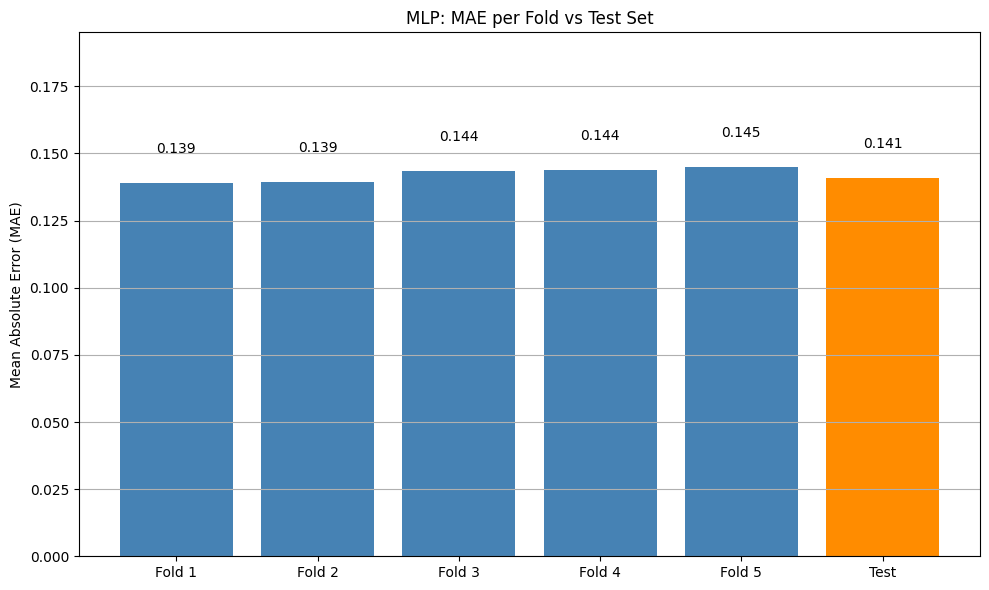

In [78]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

# Zakładam, że masz zapisane MAE dla każdego folda w `cv_maes`
# oraz przewidywania testowe z modelu końcowego (`y_pred_test`)

test_mae = mean_absolute_error(y_test, y_pred_test)

# Wykres MAE: Foldy vs Test
plt.figure(figsize=(10, 6))
bars = plt.bar([f"Fold {i+1}" for i in range(len(cv_maes))] + ["Test"],
               cv_maes + [test_mae],
               color=["steelblue"] * len(cv_maes) + ["darkorange"])
plt.title("MLP: MAE per Fold vs Test Set")
plt.ylabel("Mean Absolute Error (MAE)")
plt.ylim(0, max(cv_maes + [test_mae]) + 0.05)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

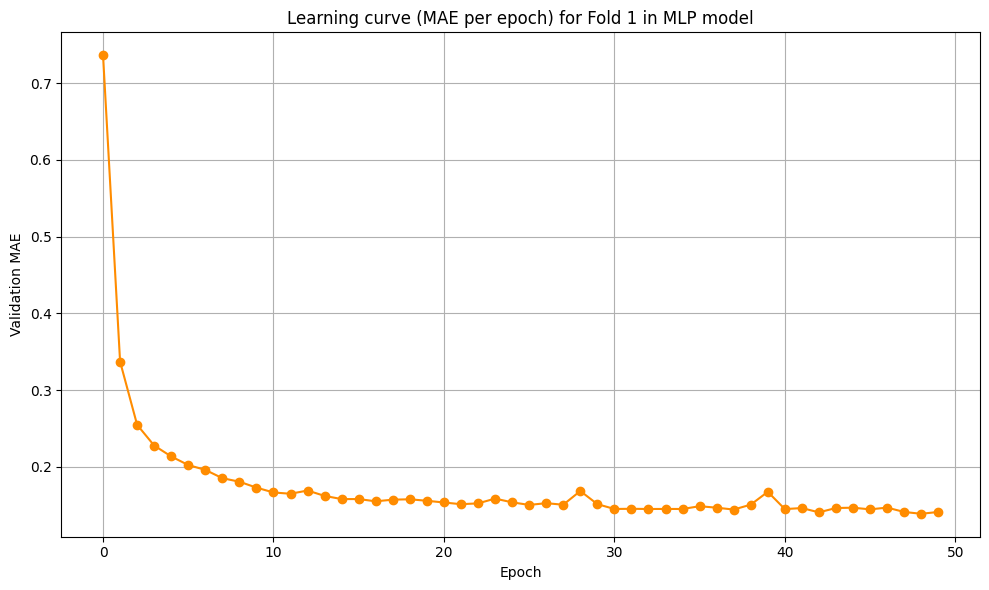

In [79]:
import matplotlib.pyplot as plt

# Wykres przebiegu MAE na walidacji dla Fold 1
plt.figure(figsize=(10, 6))
plt.plot(mae_fold1, marker='o', color='darkorange')
plt.title("Learning curve (MAE per epoch) for Fold 1 in MLP model")
plt.xlabel("Epoch")
plt.ylabel("Validation MAE")
plt.grid(True)
plt.tight_layout()
plt.show()

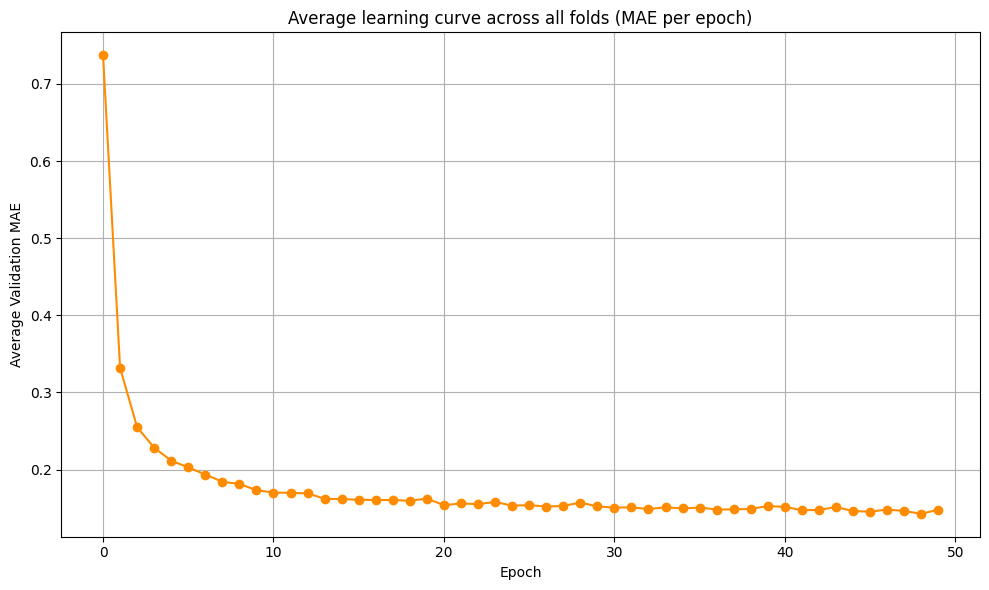

In [80]:
# Ustal najdłuższą sekwencję (różne foldy mogą kończyć wcześniej przez early stopping)
max_epochs = max(len(r) for r in all_mae_curves)

# Uzupełnij krótsze sekwencje NaN-ami i policz średnią ignorując NaN
padded = np.full((len(all_mae_curves), max_epochs), np.nan)
for i, r in enumerate(all_mae_curves):
    padded[i, :len(r)] = r
avg_mae = np.nanmean(padded, axis=0)

# Wykres średniej krzywej uczenia
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(avg_mae, marker='o', color='darkorange')
plt.title("Average learning curve across all folds (MAE per epoch)")
plt.xlabel("Epoch")
plt.ylabel("Average Validation MAE")
plt.grid(True)
plt.tight_layout()
plt.show()

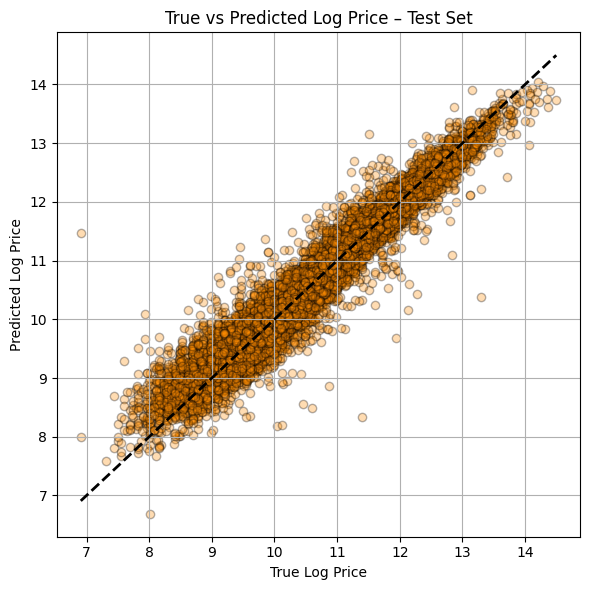

In [81]:
plt.figure(figsize=(6, 6))
plt.scatter(
    y_test.values.ravel(),     # True values (pandas Series → array)
    y_pred_test.ravel(),       # Predicted values (already ndarray)
    alpha=0.3,
    color="darkorange",
    edgecolor="k"
)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'k--', lw=2
)
plt.xlabel("True Log Price")
plt.ylabel("Predicted Log Price")
plt.title("True vs Predicted Log Price – Test Set")
plt.grid(True)
plt.tight_layout()
plt.show()